In [738]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from sklearn.discriminant_analysis import StandardScaler

In [778]:
# Read the CSV file
wo_1_1_0 = pd.read_csv("data/csv/still/0/wo_1_1_0.csv")
wo_1_1_0_o = wo_1_1_0.copy()

# Specify the columns to scale
cols = ['ant1_amplitude', 'ant2_amplitude', 'ant1_phase', 'ant2_phase', 'rssi', 'rssi1', 'rssi2']

# Initialize the StandardScaler
scaler = StandardScaler()

# Apply StandardScaler only to the specified columns
wo_1_1_0[cols] = scaler.fit_transform(wo_1_1_0[cols])

# Optionally, if you want to create a new DataFrame with only the scaled columns
# wo_1_1_0 = pd.DataFrame(wo_1_1_0, columns=cols)
wo_1_1_0 = wo_1_1_0[cols + ['nc','subcarriers','timestamps']]

# Show the head of the DataFrame
print(wo_1_1_0.head())

   ant1_amplitude  ant2_amplitude  ant1_phase  ant2_phase      rssi     rssi1  \
0       -2.241554       -0.818683    0.550737   -0.771030 -0.679725 -1.154376   
1       -2.241554        0.230267   -0.535719    1.108552 -0.679725 -1.154376   
2       -2.221138       -0.787268    0.545210   -0.808344 -0.679725 -1.154376   
3       -2.216565        0.324452   -0.556226    1.102351 -0.679725 -1.154376   
4       -2.192233       -0.854910    0.525503   -0.799598 -0.679725 -1.154376   

      rssi2  nc  subcarriers  timestamps  
0 -0.442531   2            1   429192390  
1 -0.442531   2            2   429192390  
2 -0.442531   2            3   429192390  
3 -0.442531   2            4   429192390  
4 -0.442531   2            5   429192390  


In [779]:
def hampel_filter(input_series, window_size=5, n_sigmas=3):
    """
    Apply Hampel filter to detect and replace outliers with the median of neighboring values.
    
    Parameters:
    - input_series: A Pandas Series of data points (e.g., amplitude values).
    - window_size: The number of adjacent data points to consider on each side (2*window_size+1 total window).
    - n_sigmas: The number of standard deviations beyond which a point is considered an outlier.
    
    Returns:
    - A Pandas Series with outliers replaced by the rolling median.
    """
    
    # Convert input to pandas series if not already
    input_series = pd.Series(input_series)
    
    # Calculate the rolling median and rolling standard deviation
    rolling_median = input_series.rolling(window=window_size, center=True).median()
    rolling_std = input_series.rolling(window=window_size, center=True).std()

    # Calculate the absolute difference between the points and the rolling median
    diff = np.abs(input_series - rolling_median)
    
    # Identify outliers based on the threshold (n_sigmas)
    outliers = diff > (n_sigmas * rolling_std)
    
    # Replace outliers with the median
    filtered_series = input_series.copy()
    filtered_series[outliers] = rolling_median[outliers]

    return filtered_series

In [780]:
def apply_savgol_filter(input_array, window_length=11, polyorder=3):
    # Input array is expected to be 2D: rows are sets, columns are subcarriers
    smoothed_array = np.empty_like(input_array)
    
    # Apply Savitzky-Golay filter for each subcarrier (column-wise)
    for i in range(input_array.shape[1]):  # Loop over subcarriers (columns)
        smoothed_array[:, i] = savgol_filter(input_array[:, i], window_length=window_length, polyorder=polyorder)
    
    return smoothed_array

In [781]:
import matplotlib.pyplot as plt

def plot_subcarrier_batches(df, subcarrier_col, amplitude_col):
    """
    Plots batches of subcarriers and amplitude data from a DataFrame, splitting the batches 
    when subcarrier numbers reset (i.e., when the next subcarrier number is smaller than the previous one).
    
    Parameters:
    - df: DataFrame containing the data
    - subcarrier_col: the name of the column representing the subcarrier numbers
    - amplitude_col: the name of the column representing the amplitude values
    """
    
    # Initialize the start at the first index
    start = 0
    
    # Set the figure size for plotting
    plt.figure(figsize=(10, 8))
    
    # Loop through the rows of the dataframe to plot batches of data
    i = 0
    while start < df.shape[0] - 1:
        # Find the batch end where the subcarrier number decreases (reset point)
        for end in range(start + 1, df.shape[0]):
            if df[subcarrier_col].iloc[end] < df[subcarrier_col].iloc[end - 1]:
                break
        else:
            # If no smaller number is found, use the entire remaining part
            end = df.shape[0]
        
        # Extract the subcarrier and amplitude data for this batch using .iloc for position-based indexing
        subcarriers_batch = df[subcarrier_col].iloc[start:end]
        amplitude_batch = df[amplitude_col].iloc[start:end]
        
        # Plot the batch with markers
        plt.plot(subcarriers_batch, amplitude_batch, label=f"Batch {i+1}", marker='o')
        
        # Update the start for the next batch
        start = end
        i += 1
    
    # Adding labels and title
    plt.xlabel("Subcarriers")
    plt.ylabel("Amplitude")
    plt.title("Ant1 Amplitude vs Subcarriers for Batches with Subcarrier Resets")
    
    # Uncomment the following line to add a legend if desired
    # plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


In [782]:
import matplotlib.pyplot as plt

def scatter_subcarrier_batches(df, subcarrier_col, amplitude_col):
    """
    Plots batches of subcarriers and amplitude data from a DataFrame, splitting the batches 
    when subcarrier numbers reset (i.e., when the next subcarrier number is smaller than the previous one).
    
    Parameters:
    - df: DataFrame containing the data
    - subcarrier_col: the name of the column representing the subcarrier numbers
    - amplitude_col: the name of the column representing the amplitude values
    """
    
    # Initialize the start at the first index
    start = 0
    
    # Set the figure size for plotting
    plt.figure(figsize=(10, 8))
    
    # Loop through the rows of the dataframe to plot batches of data
    i = 0
    while start < df.shape[0] - 1:
        # Find the batch end where the subcarrier number decreases (reset point)
        for end in range(start + 1, df.shape[0]):
            if df[subcarrier_col].iloc[end] < df[subcarrier_col].iloc[end - 1]:
                break
        else:
            # If no smaller number is found, use the entire remaining part
            end = df.shape[0]
        
        # Extract the subcarrier and amplitude data for this batch using .iloc for position-based indexing
        subcarriers_batch = df[subcarrier_col].iloc[start:end]
        amplitude_batch = df[amplitude_col].iloc[start:end]
        
        # Plot the batch with markers
        plt.scatter(subcarriers_batch, amplitude_batch, label=f"Batch {i+1}", marker='o')
        
        # Update the start for the next batch
        start = end
        i += 1
    
    # Adding labels and title
    plt.xlabel("Subcarriers")
    plt.ylabel("Amplitude")
    plt.title("Ant1 Amplitude vs Subcarriers for Batches with Subcarrier Resets")
    
    # Uncomment the following line to add a legend if desired
    # plt.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()


# NC1

In [783]:
wo_1_1_0_nc_1 = wo_1_1_0[wo_1_1_0['nc'] == 1]
wo_1_1_0_nc_1.head()

,ant1_amplitude,ant2_amplitude,ant1_phase,ant2_phase,rssi,rssi1,rssi2,nc,subcarriers,timestamps
112,0.640415,1.380673,0.000149,-1.522916,-0.319632,-0.091096,-0.442531,1,1,429193757
113,0.482076,1.422243,-0.072677,-1.582177,-0.319632,-0.091096,-0.442531,1,2,429193757
114,0.413533,1.672511,-0.120131,-1.614320,-0.319632,-0.091096,-0.442531,1,3,429193757
115,0.332721,1.727107,-0.183078,-1.674303,-0.319632,-0.091096,-0.442531,1,4,429193757
116,0.174818,1.493885,-0.253829,1.689273,-0.319632,-0.091096,-0.442531,1,5,429193757


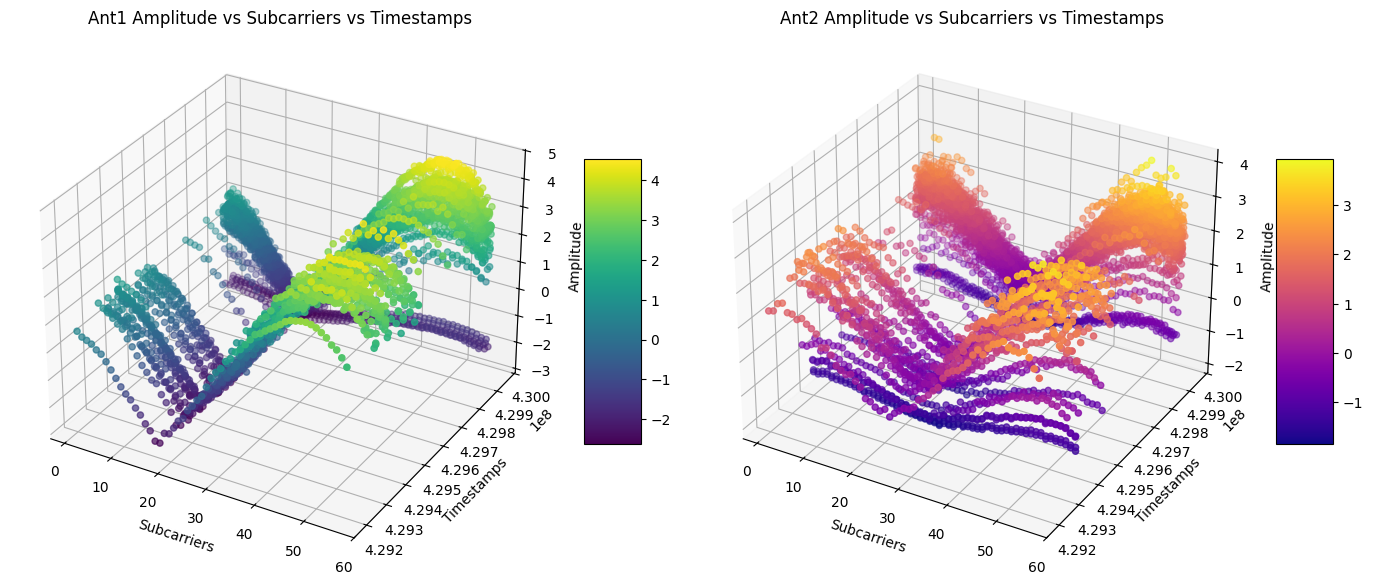

In [784]:
# Create a figure with two subplots for side-by-side 3D scatter plots
fig = plt.figure(figsize=(14, 6))

# First subplot for Ant1 Amplitude
ax1 = fig.add_subplot(121, projection='3d')
subcarriers = wo_1_1_0_nc_1["subcarriers"]
amplitude_ant1 = wo_1_1_0_nc_1["ant1_amplitude"]
timestamps = wo_1_1_0_nc_1["timestamps"]

# 3D scatter plot for Ant1
# scatter1 = ax1.scatter(subcarriers, timestamps, amplitude_ant1, c=amplitude_ant1, cmap='viridis')
scatter1 = ax1.scatter(subcarriers, timestamps, amplitude_ant1, c=amplitude_ant1, cmap='viridis')
ax1.set_xlabel('Subcarriers')
ax1.set_ylabel('Timestamps')
ax1.set_zlabel('Amplitude')
ax1.set_title('Ant1 Amplitude vs Subcarriers vs Timestamps')
fig.colorbar(scatter1, ax=ax1, shrink=0.5, aspect=5)

# Second subplot for Ant2 Amplitude
ax2 = fig.add_subplot(122, projection='3d')
amplitude_ant2 = wo_1_1_0_nc_1["ant2_amplitude"]

# 3D scatter plot for Ant2
scatter2 = ax2.scatter(subcarriers, timestamps, amplitude_ant2, c=amplitude_ant2, cmap='plasma')
ax2.set_xlabel('Subcarriers')
ax2.set_ylabel('Timestamps')
ax2.set_zlabel('Amplitude')
ax2.set_title('Ant2 Amplitude vs Subcarriers vs Timestamps')
fig.colorbar(scatter2, ax=ax2, shrink=0.5, aspect=5)

# Adjust layout and display
plt.tight_layout()
plt.show()

In [785]:
wo_1_1_0_nc_1_ant1 = wo_1_1_0_nc_1[['subcarriers', 'ant1_amplitude']]


In [786]:
grouped = wo_1_1_0_nc_1_ant1.groupby('subcarriers')['ant1_amplitude'].apply(list)
filtered_data = grouped.apply(lambda x: hampel_filter(x, window_size=280, n_sigmas=3))

In [787]:
filtered_data_1d = []

for j in range(filtered_data.shape[1]):
    for i in range(1, filtered_data.shape[0]+1):
        filtered_data_1d.append(filtered_data[j][i])
        
print(filtered_data_1d)

[0.6404151968135557, 0.4820755781839928, 0.4135326312786034, 0.33272091834289036, 0.17481752068192372, 0.07261645471343554, -0.14649331858840883, -0.39296030224136097, -0.645030931834268, -0.9022085137484983, -1.1076361874837695, -1.2677819838694828, -1.513005218290056, -1.7141713119862927, -1.9812559026253294, -2.1834674226572366, -2.5103484966554754, -2.5246924341354076, -2.1103917178019307, -2.0729896588815837, -1.802213659434768, -1.4943768855639934, -1.3505396966076446, -1.0069694014493682, -0.786734067749489, -0.5203670481712601, -0.3233385251625977, 0.05711573181531362, 0.42762493570552723, 0.6915587991891944, 0.8760011022609289, 1.1773269172603273, 1.3285209623080199, 1.6143862697485234, 1.7562779585532229, 1.9766936492597584, 2.199633076722454, 2.428252626423167, 2.5178509194075116, 2.6579505590608203, 2.780754834253485, 2.901702327725515, 3.030254842799166, 3.183089512150768, 3.270856045882191, 3.3064248870354436, 3.353015213649885, 3.366051435396305, 3.338444801626421, 3.276

In [788]:
wo_1_1_0_nc_1_ant1['filtered_ant1_amplitude'] = filtered_data_1d

/tmp/ipykernel_42020/2712486316.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wo_1_1_0_nc_1_ant1['filtered_ant1_amplitude'] = filtered_data_1d


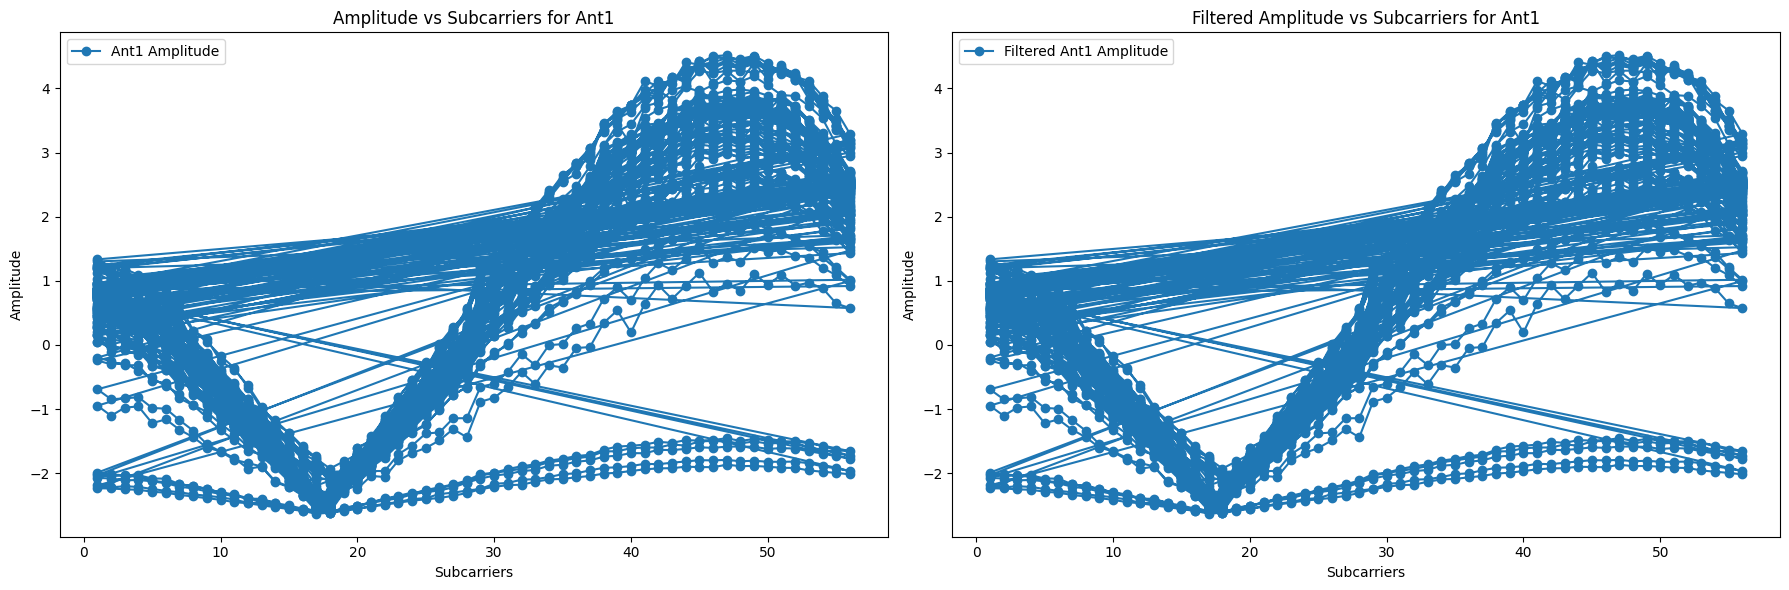

In [803]:
fig, ax = plt.subplots(1, 2, figsize=(18, 6))

ax[0].plot(wo_1_1_0_nc_1["subcarriers"], wo_1_1_0_nc_1["ant1_amplitude"], label="Ant1 Amplitude", marker='o')
ax[0].set_xlabel("Subcarriers")
ax[0].set_ylabel("Amplitude")
ax[0].set_title("Amplitude vs Subcarriers for Ant1")
ax[0].legend()

ax[1].plot(wo_1_1_0_nc_1_ant1["subcarriers"], wo_1_1_0_nc_1_ant1["filtered_ant1_amplitude"], label="Filtered Ant1 Amplitude", marker='o')
ax[1].set_xlabel("Subcarriers")
ax[1].set_ylabel("Amplitude")
ax[1].set_title("Filtered Amplitude vs Subcarriers for Ant1")
ax[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

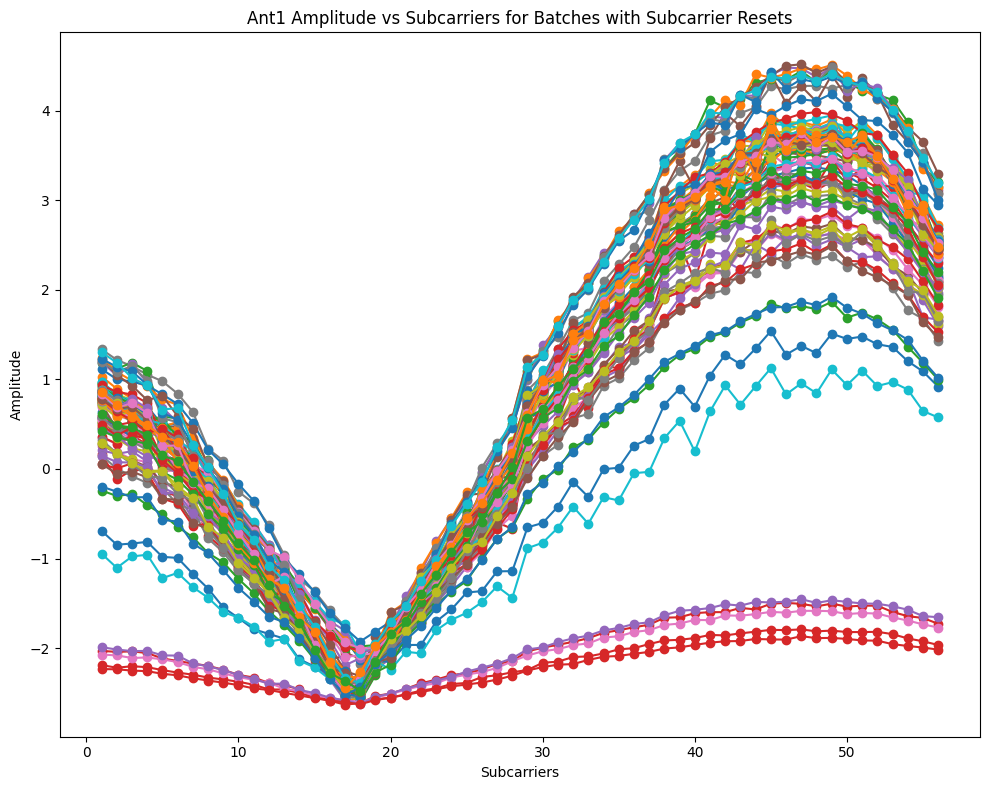

In [790]:
plot_subcarrier_batches(wo_1_1_0_nc_1_ant1, "subcarriers", "filtered_ant1_amplitude")

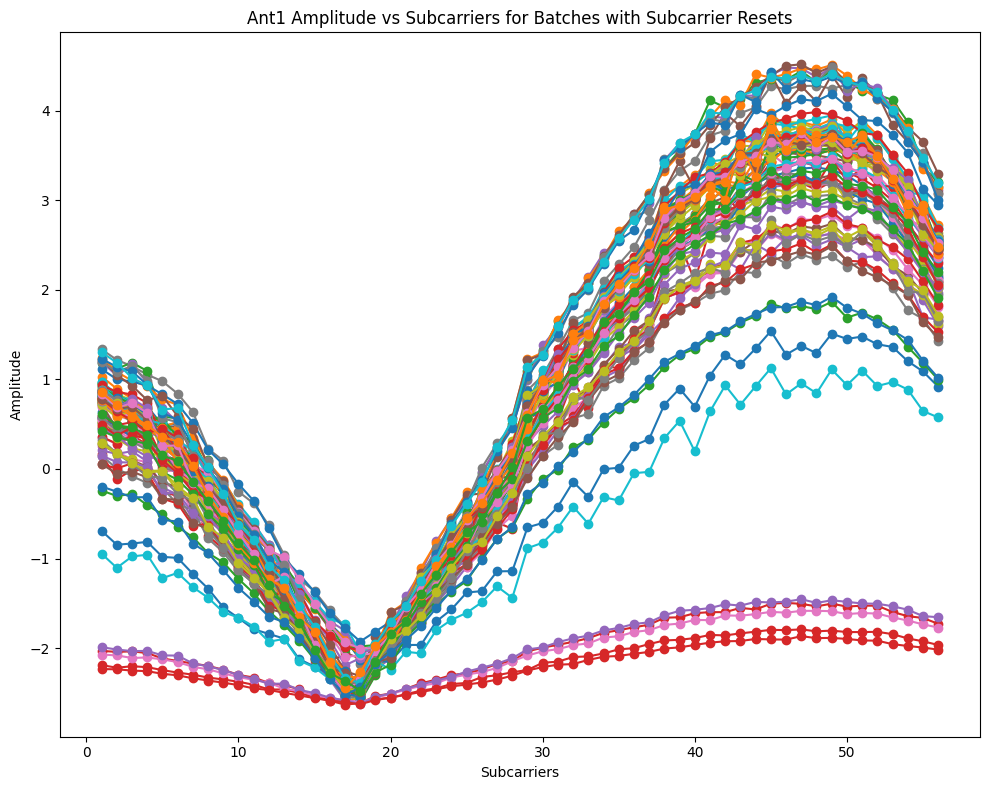

In [791]:
plot_subcarrier_batches(wo_1_1_0_nc_1, "subcarriers", "ant1_amplitude")

In [792]:
wo_1_1_0_nc_1_ant1['sg_ant1_amplitude'] = savgol_filter(wo_1_1_0_nc_1_ant1['filtered_ant1_amplitude'], window_length=5, polyorder=2)


/tmp/ipykernel_42020/2069847597.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wo_1_1_0_nc_1_ant1['sg_ant1_amplitude'] = savgol_filter(wo_1_1_0_nc_1_ant1['filtered_ant1_amplitude'], window_length=5, polyorder=2)


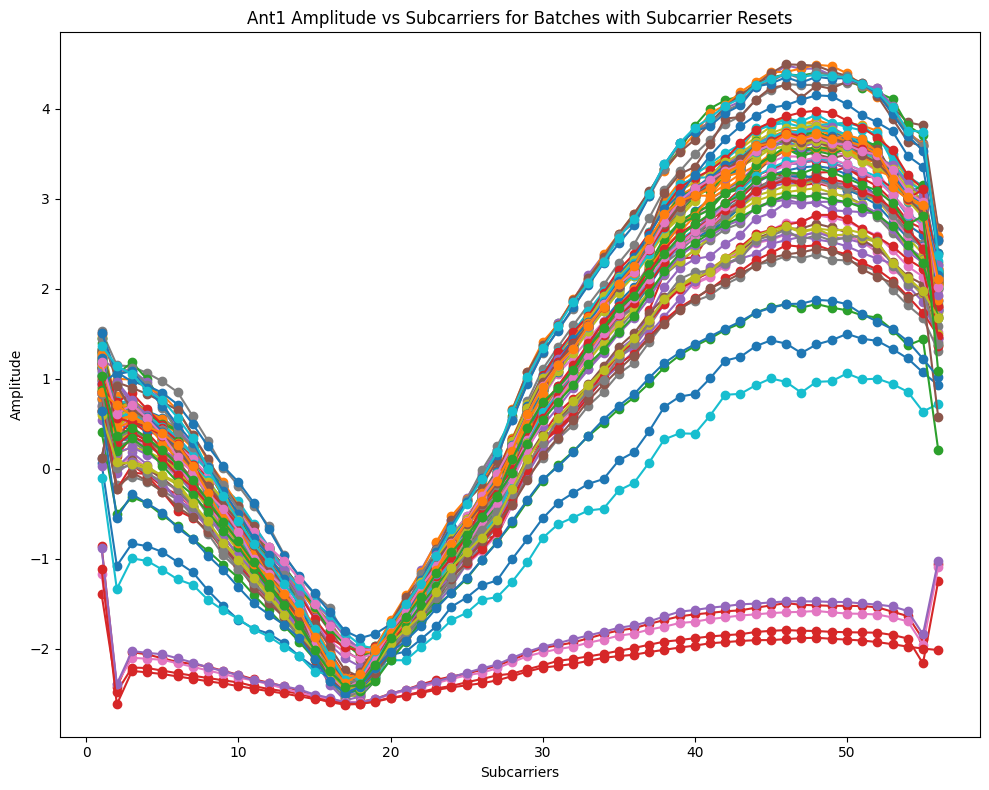

In [793]:
plot_subcarrier_batches(wo_1_1_0_nc_1_ant1, "subcarriers", "sg_ant1_amplitude")

# HDBSCAN

In [794]:
import hdbscan

In [795]:
wo_1_1_0_nc_1_ant1_sg = wo_1_1_0_nc_1

In [796]:
wo_1_1_0_nc_1_ant1_sg = wo_1_1_0_nc_1[['ant1_amplitude', 'subcarriers']]
wo_1_1_0_nc_1_ant1_sg['sg_ant1_amplitude'] = savgol_filter(wo_1_1_0_nc_1_ant1_sg['ant1_amplitude'], window_length=5, polyorder=2)

/tmp/ipykernel_42020/2733814413.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wo_1_1_0_nc_1_ant1_sg['sg_ant1_amplitude'] = savgol_filter(wo_1_1_0_nc_1_ant1_sg['ant1_amplitude'], window_length=5, polyorder=2)


In [797]:
wo_1_1_0_nc_1_ant1_sg_dbscan = wo_1_1_0_nc_1_ant1_sg[['sg_ant1_amplitude','subcarriers']]

In [798]:
ant1_dbscan = hdbscan.HDBSCAN(min_samples=wo_1_1_0_nc_1_ant1_sg_dbscan.shape[1]*2, core_dist_n_jobs=-1)
ant1_dbscan.fit(wo_1_1_0_nc_1_ant1_sg_dbscan)
wo_1_1_0_nc_1_ant1_sg_dbscan['ant1_amplitude_cluster'] = ant1_dbscan.labels_
wo_1_1_0_nc_1_ant1_sg_dbscan.drop(wo_1_1_0_nc_1_ant1_sg_dbscan[wo_1_1_0_nc_1_ant1_sg_dbscan.ant1_amplitude_cluster < 0].index, inplace=True)

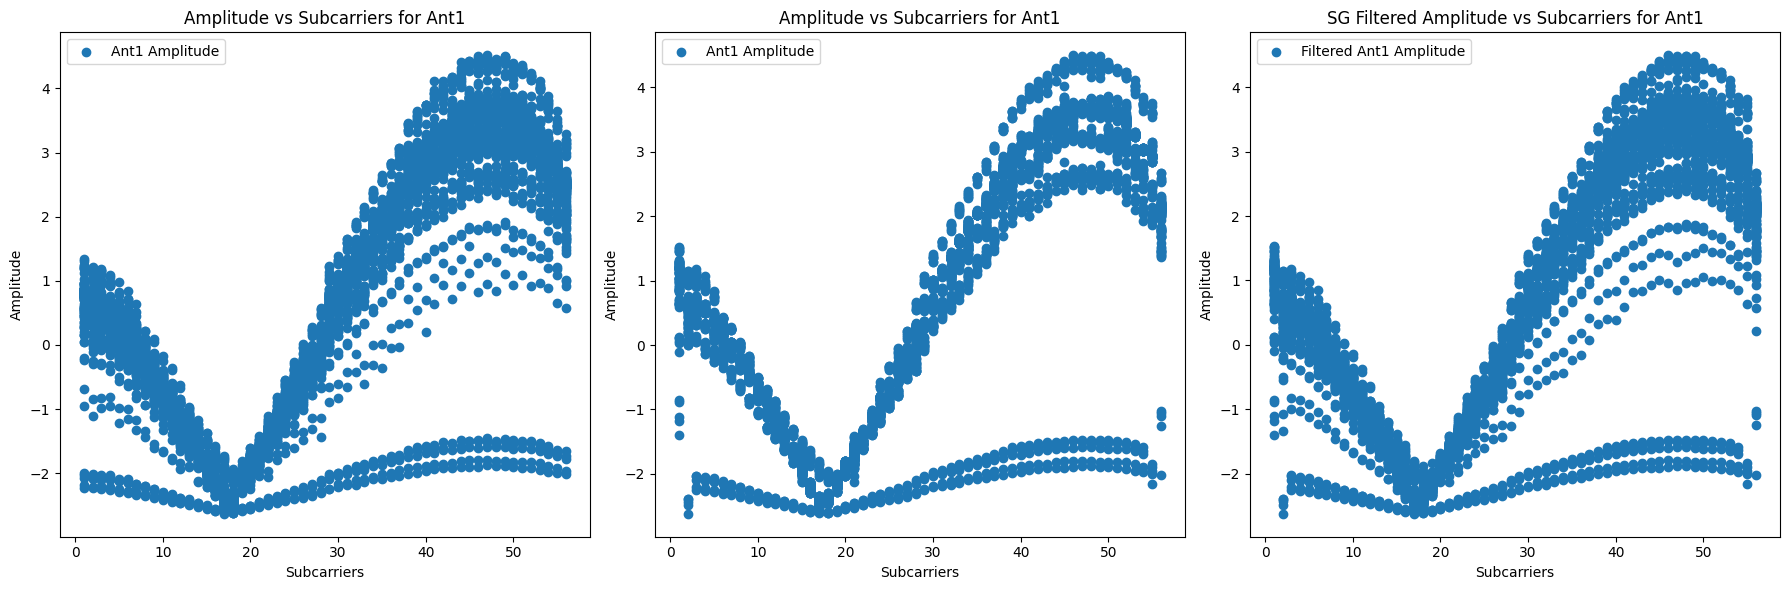

In [799]:
fig, ax = plt.subplots(1, 3, figsize=(18, 6))

ax[0].scatter(wo_1_1_0_nc_1["subcarriers"], wo_1_1_0_nc_1["ant1_amplitude"], label="Ant1 Amplitude", marker='o')
ax[0].set_xlabel("Subcarriers")
ax[0].set_ylabel("Amplitude")
ax[0].set_title("Amplitude vs Subcarriers for Ant1")
ax[0].legend()

ax[2].scatter(wo_1_1_0_nc_1_ant1_sg["subcarriers"], wo_1_1_0_nc_1_ant1_sg["sg_ant1_amplitude"], label="Filtered Ant1 Amplitude", marker='o')
ax[2].set_xlabel("Subcarriers")
ax[2].set_ylabel("Amplitude")
ax[2].set_title("SG Filtered Amplitude vs Subcarriers for Ant1")
ax[2].legend()

ax[1].scatter(wo_1_1_0_nc_1_ant1_sg_dbscan["subcarriers"], wo_1_1_0_nc_1_ant1_sg_dbscan["sg_ant1_amplitude"], label="Ant1 Amplitude", marker='o')
ax[1].set_xlabel("Subcarriers")
ax[1].set_ylabel("Amplitude")
ax[1].set_title("Amplitude vs Subcarriers for Ant1")
ax[1].legend()

# Adjust layout and display the plots
plt.tight_layout()
plt.show()

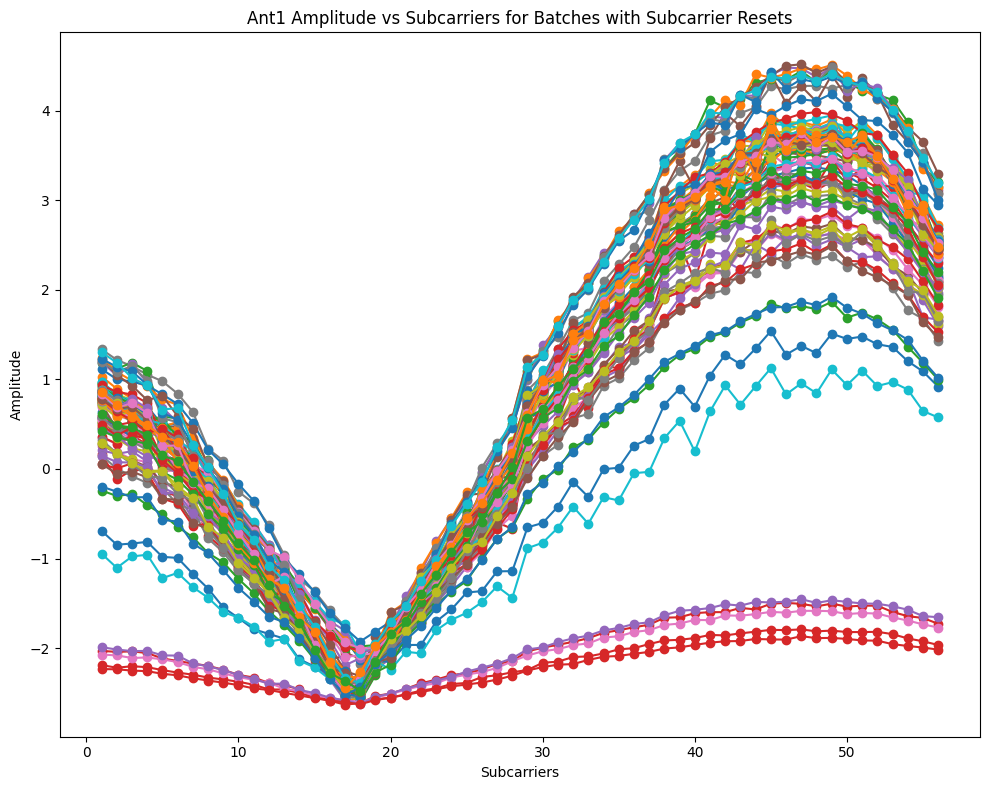

In [804]:
scatter_subcarrier_batches(wo_1_1_0_nc_1, "subcarriers", "ant1_amplitude")

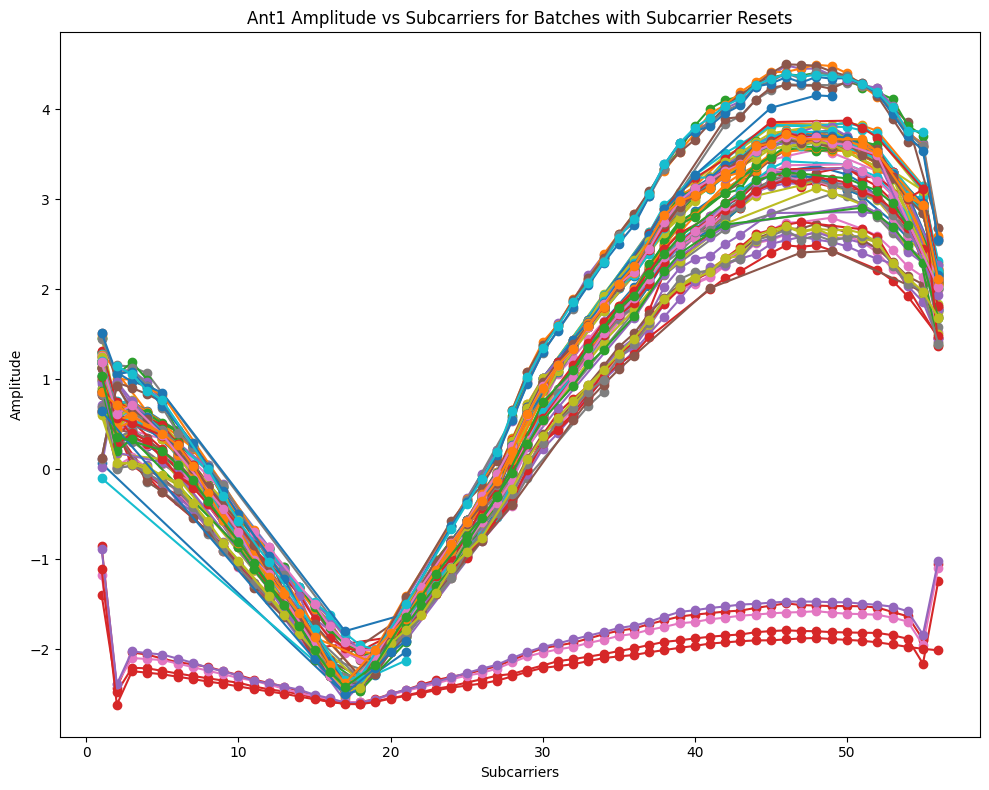

In [805]:
plot_subcarrier_batches(wo_1_1_0_nc_1_ant1_sg_dbscan, "subcarriers", "sg_ant1_amplitude")

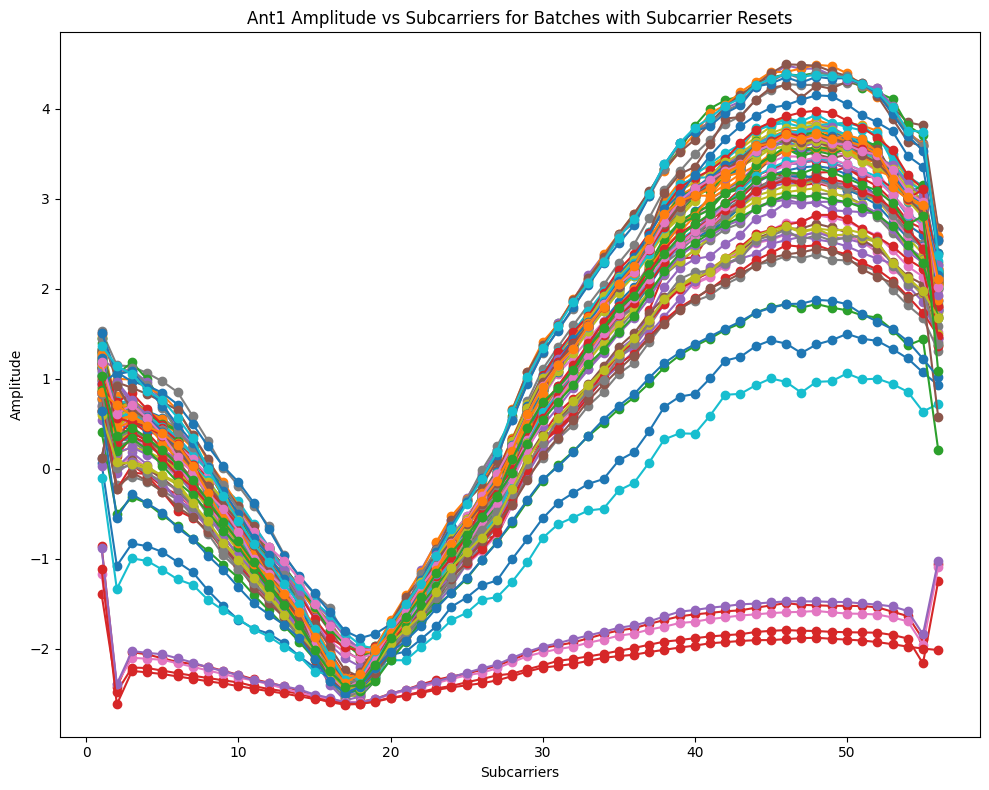

In [806]:
plot_subcarrier_batches(wo_1_1_0_nc_1_ant1_sg, "subcarriers", "sg_ant1_amplitude")